## Bullet Trajectories - An Exploration of Simulated Bullet Flight Paths

## Introduction

Flight dynamics for ballistic objects are an important field. Recent gains in the availability of published data and improved reference models have improved a shooter's ability to understand the characteristics of a bullets flight path beyond simply firing and observing. This notebook will analyze published to compare various simulated flight paths against measured data. A bullet's trajectories is characterized by it's individual ballistic coefficient, which is a numerical way to indicate how a ballistic object is affected by air resistance. Ballistic coefficients are measured by their relation to a reference model, which eases the ability to predict performance of an unknown trajectory by comparison to a measured reference model. Long holding the title of the industry standard reference model is the G1 model, pioneered in the late 19th Century. Advancements in analysis techniques have created new reference models, one which has made a particular mark is the G7 model. 

It is commonly known that different reference models perform better for a given round based on the chacteristics of the round, notably the shape of the round. The following image shows the profile of the reference rounds that this notebook will analyze. 

![Reference Bullet Models](Gmodels.png)

### Dependencies

The following imports are used throughout this notebook.

In [1]:
#Dependencies
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
from scipy.interpolate import interp1d
from scipy.optimize import fmin

### Theory

The calculations in this notebook will rely on a fundamental understanding of the physics involved, the primary of which is the drag force which is commonly expressed as 

$$\mathbf{F}_d= -{1 \over 2} \rho v^2 A C_d \mathbf{\hat v}$$

where $C_d$ is the non-dimensional drag coefficient, $\rho$ is the density of the air, $|v|$ is the magnitude of velocity, and $\mathbf{\hat v} = \frac{\mathbf{v}}{|\mathbf{v}|}$ the normalized velocity direction. Mass is a factor of $C_d$.

The only factor in this equation that is specific to the bullet in question is $C_d$ which presents the problem this notebook seeks to explore: how to determine $C_d$ in a simulated state to accurately model the flight path. Complicating matters is the fact that $C_d$ will vary with the speed of the bullet.

To enable our calculation of drag based on a reference model we seek to encapsulate their relation, which is defined as: The form factor of a bullet,  $f=\frac{C_d}{C^{\mathbf{G}}_{d}}$, where $C_d$ is the bullet's coefficient of drag, and $C^{\mathbf{G}}_{d}$ is the drag of a reference round.

The sectional density of a bullet is defined as $S_d = \frac{m}{A}$. It is the mass $m$ divided by the cross-sectional area $A$ of the bullet.

The **ballistic coefficient** is then the amount a bullet slows down in flight relative to a reference round. Based on the previous relations, this is expressed as

$$b_c = \frac{S_d}{f}$$

This is the number provided by manufactures to indicate how well the bullet travels through the air. A value of 1.0 means the bullet has the same drag as the reference round. A value of greater than one would indicate the bullet experiences less drag than the reference round. A value less than one indicates the bullet experiences more drag than the reference round.

In conclusion, to model the trajectory of a round, we use published data on a reference round, and then compute how much the trajectory changes for a particular round. The difference between the reference round and the round in question is expressed as the inverse of the ballistic coefficient, $b_c$. A value of $b_c$ less than one indicates the round is impacted more by air resistance than the reference round. A value of $b_c$ greater than one indicates the projectile experiences less air resistance than the reference round.

### Full Form of the Drag Acceleration

To arrive at a usable form for simulation, we multiply the drag force by $\frac{b_c}{b_c}$ and expand the ballistic coefficient in terms of sectional density and form factor. After cancellation and dividing through by mass to express the result as acceleration, we generalize $C_d$ to be a function of Mach number:

$$m = \frac{|\mathbf{v}|}{v_s}$$

where $v_s$ is the speed of sound in air. The result is that any round's trajectory can be expressed as a reference round's drag scaled by the ballistic coefficient of the particular round:

$$\mathbf{a_d} = -\frac{1}{2b_c} \rho C_d^G(m) |v|^2\mathbf{\hat v}$$

Partitioning this into $x$ and $y$ components via $\mathbf{\hat v}$ yields the two-dimensional equations of motion used throughout this notebook:

$$a_x = - \frac{1}{2b_c}C_d^G(m) v^{2}\frac{v_x}{|\mathbf{v}|}$$

$$a_y = -g - \frac{1}{2b_c}C_d^G(m) v^{2}\frac{v_y}{|\mathbf{v}|}$$

These equations form the core of the simulation. For any given bullet, only the ballistic coefficient $b_c$ and initial muzzle velocity need to be known — the drag behavior is then determined entirely by the reference model's $C_d^G(m)$ curve.

### Scope of Analysis

The first step in this analysis is to create reference drag models from measured G1 and G7 experimental data. These reference curves of $C_d^G(m)$ will be used as $C^{\mathbf{G}}_{d}$ in the above equations.

The primary dataset analyzed is published by the Hornady Corporation, which provides the following data for a wide catalog of bullets:

- **Cartridge and Bullet** — bullet type, cartridge, weight, and powder charge
- **Ballistic Coefficient** — based on the G1 reference model
- **Velocity** — chronograph measurements at ranges from 0 to 300 m
- **Energy** — computed or measured energy at the same ranges
- **Trajectory/Drop** — measured height relative to line of sight at each range
- **GEE** — the maximum range of the flattest possible firing angle
- **GEE Trajectory** — the trajectory of that flattest curve

Analysis will include trajectory comparison against measured data, firing angle optimization to zero at 100 m, and quantitative assessment of model fit using both G1 and G7 models.

Additionally, supplemental data published by Hornady provides G7 ballistic coefficients and more granular, velocity-dependent BC values for select bullets. These will be used to compare model accuracy between G1 and G7 reference frames.

## Methods


### Methods of Simulation

Our simulation today will be an ODE (Ordinary Differential Equation) simulation. This type of simulation takes an input parameter, which we call $y_0$. The simulation is then iterated upon by utilizing a flexible function to encapsulate physical behavior over given timesteps. In our case the ODE will be given a projectile function which will calculate how the state of the system should change based on it's current conditions, this includes positions and the coefficients of drag mentioned above. This change will then be applied by the ODE on a timestep to advance the simulation.

An ODE simulator operates over a given timespan, and can use different methods for approximating change. Among those are Euler (first point sampling), Euler-Cromer (end point sampling), and Euler-Richardson (mid-point sampling). Our simulation focuses on acceleration, which is the second deriviative of position, as such Euler-Richardson proves to be the most accurate method. To learn more about Euler-Richardson, the University of Delaware has an informative [website](https://www.physics.udel.edu/~bnikolic/teaching/phys660/numerical_ode/node4.html).

For the purposes of this simulation our state vector will include the position and velocity of the bullet:
[x, y, $V_x$, $V_y$]

Our functions for the ODE solver are as follows:

> **Note:** The ODE solver in this notebook has been modified from a general form to accept an ending y value to terminate simulation as needed.

In [2]:
def EulerRichardson(dt, f, t, y, args): #Midpoint sampling
    y_mid = y + f(t, y, *args) * (dt / 2) #Gives us the velocity at the midpoint
    return y + f(t + dt/2, y_mid, *args) * dt #We calculate overall difference using midpoint velocity. y + velocity at midpoint * dt

def solve_ode(f, tspan, y0, method=EulerRichardson, *args, **options):
    """
    Given a function f that returns derivatives,
    dy / dt = f(t, y, *args)
    and an initial state:
    y(tspan[0]) = y0
    
    This function will return the set of intermediate states of y
    from t0 (tspan[0]) to tf (tspan[1])
    
    first_step: dt
    y_ground: y position to end at
    """

    dt = options.get('first_step', 0.1)
    y_ground = options.get('y_ground', None)
    
    numsteps = int((tspan[1] - tspan[0]) / dt)

    y = []
    y.append(y0)
    
    t = []
    t.append(tspan[0])
    
    has_risen = False
    
    for i in range(1, numsteps):
        t.append(tspan[0] + i * dt)
        y.append(method(dt, f, t[i-1], y[i-1], args))
        
        #Cut off simulation when bullet hits the y target/ground
        if y_ground is not None:
            if y[-1][1] > y_ground:
                has_risen = True
            if has_risen and y[-1][1] <= y_ground:
                break
        
    return np.array(y), np.array(t)

### Projectile Function

The ODE solver above is general-purpose, it needs a function that defines the physics of the system. The `projectile` function fills this role. Given the current state vector $[x, y, v_x, v_y]$ and a `Ballistics` object, it computes the derivatives $[v_x, v_y, a_x, a_y]$ at each timestep. The drag acceleration is obtained from the `Ballistics` object's `get_drag` method and projected onto each axis proportional to the velocity components. Gravity acts only in the $y$ direction. This is the direct implementation of the equations of motion derived in the Theory section.

In [3]:
def projectile(t, y, b):
    """
    To be given to an ODE integrator to find the trajectory of a bullet.
    given y, returns dydt
    b is an object assumed to contain:
        b.g - gravitational acceleration
        b.get_drag - a function that returns the drag acceleration, given the magnitude of velocity.
    """
    #Unpack y
    x0, y0, vx, vy = y
    
    #Get magnitude of velocity
    v_mag = np.sqrt(vx**2 + vy**2)

    if v_mag == 0:
        return np.array([0, 0, 0, -b.g])

    #Get drag force
    F_drag = b.get_drag(v_mag)
    
    #calculate components of acceleration
    ax = -F_drag * (vx/v_mag)
    ay = -F_drag * (vy/v_mag) - b.g
    
    return np.array([vx, vy, ax, ay])

### Ballistics Class

To run simulations we need a way to encapsulate the reference models and bullet-specific data into a single reusable object. The `Ballistics` class serves this purpose. At its core, the class loads reference model data (G1 or G7) and builds an interpolation function over the tabulated $K_d(m)$ values using `scipy.interpolate.interp1d`. This allows the model to return a continuous $C_d^G(m)$ at any Mach number, applying the conversion $C_d = \frac{\pi}{4} K_d$.

The class caches reference model data at the class level so that multiple bullet instances sharing the same reference model (e.g., all G1 bullets) do not redundantly read from disk.

Each instance stores the bullet's ballistic coefficient $b_c$ converted from the manufacturer-reported imperial units (lb/in²) to metric (kg/m²) via a factor of 703. For bullets where velocity-dependent $b_c$ data is available from the supplemental Hornady dataset, the class instead builds an interpolation function over paired Mach number and $b_c$ values, enabling a more granular drag calculation.

The primary interface is the `get_drag(v)` method, which takes velocity magnitude and returns the unsigned drag acceleration — this is the quantity that feeds directly into the ODE equations of motion described in the Theory section.

In [4]:
class Ballistics():
    #class level model
    _models = {}
    
    @classmethod
    #Receives class, not itself (cls vs self)
    #class based instance of interpolation function saves memory. Basically when the first ballistics
    #object looks for a particular model it will read the csv and add that to models. Subsequent calls
    #to _get_model will use this
    def _get_model(cls, reference_model):
        if reference_model not in cls._models:
            if reference_model == "G1":
                data = pd.read_csv('G1.csv').values
            elif reference_model == "G7":
                data = pd.read_csv('G7.csv').values
                
            cls._models[reference_model] = interp1d(data[:, 0], data[:, 1])
            
        return cls._models[reference_model]
    
    def __init__(self, g=9.8, p=1.225, B_c=1, cartridge=None, bullet=None, reference_model="G1",
                 mach_numbers=None, bc_values=None):
        #gravity
        self.g = g
        #air density in kg/m^3
        self.p = p
        #Cartdige name
        self.cartridge = cartridge
        self.bullet = bullet
        
        # Get shared reference model from class cache (no redundant file reads)
        self.model = Ballistics._get_model(reference_model)
        self.reference_model = reference_model
        
        # If mach_numbers and bc_values are provided, create an interpolated B_c function
        # Otherwise, use the scalar B_c value (converted from lb/in^2 to kg/m^2)
        if mach_numbers is not None and bc_values is not None:
            bc_metric = np.array(bc_values) * 703
            self.B_c = interp1d(mach_numbers, bc_metric, fill_value="extrapolate")
        else:
            self.B_c = B_c * 703
        
    def B_C(self, mach_number):
        #If we have a bc interpolation function, return that value else our singular ballistic coefficient.
        if callable(self.B_c):
            return self.B_c(mach_number)
        else:
            return self.B_c
        
    def Kd_to_Cd(self, Kd):
        #Correct data to coefficient of drag
        return (np.pi/4)*Kd
    
    def Cd(self, mach_number):
        #Get interpolated coefficient of drag from reference model
        return self.Kd_to_Cd(self.model(mach_number))
        
    def mach_number(self, velocity):
        #Assuming velocity is meters/second
        return (velocity/343)

    def velocity(self, mach_number):
        #Assuming velocity is meters/second
        return (mach_number*343)
    
    def get_drag(self,v):
        # Computes the drag resistance
        # this is unsigned and should be
        # working against the direction of motion
        # This also is computed with 1/m already accounted for
        # so it is acceleration, not force.,
        
        v_mag = abs(v)
        
        mach = self.mach_number(v_mag)
        
        # Computes the drag acceleration magnitude (unsigned)
        # Use B_C() so it works for both scalar and interpolated B_c
        toReturn = 0.5 * (1/self.B_C(mach)) * self.p
        toReturn *= self.Cd(mach)
        toReturn *= v_mag**2
        return toReturn

### Data Intake

Now that the simulation, physics engine, and ballistic object are established the next step is data intake. This data entering this program will come from 4 csv files:

| File | Description |
|------|-------------|
| `G1.csv` | G1 trial run, used to create $C^{\mathbf{G}}_{d}$ |
| `G7.csv` | G7 trial run, used to create $C^{\mathbf{G}}_{d}$ |
| `hornady_ballistics.csv` | Master list provided by [Hornady](https://static.hornady.media/presscenter/docs/1410998059-2022-Metric-Ballistics-Chart.pd) |
| `hornady_bc_values.csv` | Supplemental ballistic coefficient data compiled from [Hornady](https://www.hornady.com/bc) |


Below is the code for data intake.

In [5]:
#Read G1 and G7 reference model data
G1_data = pd.read_csv('G1.csv').values
G7_data = pd.read_csv('G7.csv').values
print(f"Loaded G1 reference model: {len(G1_data)} data points.")
print(f"Loaded G7 reference model: {len(G7_data)} data points.")

#Read Hornady master ballistics CSV, double header so accessing requires both header infos
hornady_df = pd.read_csv('hornady_ballistics.csv', header=[0, 1])
print(f"Loaded {len(hornady_df)} bullets from Hornady master CSV.")

#Read supplemental G7 ballistic coefficient data
expanded_df = pd.read_csv('hornady_bc_values.csv')
print(f"Loaded {len(expanded_df)} bullets from supplemental BC CSV.")

#Get names for velocity/drop/energy columns at range intervals
ranges = [0, 50, 100, 150, 200, 250, 300]
velocity_cols = [('Velocity (m/sec)', str(r)+'m') for r in ranges]
energies_cols = [('Energy (joules)', str(r)+'m') for r in ranges]
trajectory_cols = [('Trajectory Tables (cm)', str(r)+'m') for r in ranges]
gee_cols = [('GEE Trajectory', str(r)+'m') for r in ranges]

Loaded G1 reference model: 79 data points.
Loaded G7 reference model: 84 data points.
Loaded 260 bullets from Hornady master CSV.
Loaded 32 bullets from supplemental BC CSV.


### Cartridge Selection and Data Parsing

Before running simulations, we extract the measured data from the Hornady master CSV for every bullet in the catalog. A `Ballistics` object is created for each bullet under both the G1 and G7 reference models using the published G1 ballistic coefficient.

From this full catalog we select a subset of cartridges for close analysis. Modify entries in bullet_indices to add or remove bullets, there is no limit to the length.

In [6]:
#selected bullet indices
bullet_indices = [13, 84, 150, 257, 259]

#load all bullets from csv
all_velocity_data = []
all_drop_data = []
all_ballistics_G1 = []
all_ballistics_G7 = []
all_measured_gee = []

for index in range(len(hornady_df)):
    row = hornady_df.iloc[index]
    
    #perhaps redundant to store ranges for each velocity and drop but this keeps it generalizable if we get data that has different ranges
    velocity = np.array([[r, row[col]] for r, col in zip(ranges, velocity_cols) 
                          if not pd.isna(row[col])], dtype=float)
    all_velocity_data.append(velocity)
    
    drop = np.array([[r, row[col]] for r, col in zip(ranges, trajectory_cols) 
                          if not pd.isna(row[col])], dtype=float)
    
    #convert cm to meters on data intake to simplify things
    if len(drop) > 0:
        drop[:, 1] = drop[:, 1] / 100
    all_drop_data.append(drop)
    
    #Get other data for bullet
    B_c = row[('B.C.', 'B.C.')]
    cartridge = row[('CARTRIDGE', 'CARTRIDGE')]
    bullet = row[('BULLET', 'BULLET')]
    
    #measured GEE range from Hornady data
    measured_gee = row[('GEE', 'GEE')]
    all_measured_gee.append(float(measured_gee) if not pd.isna(measured_gee) else 0.0)
    
    all_ballistics_G1.append(Ballistics(B_c=B_c, cartridge=cartridge, bullet=bullet, reference_model="G1"))
    all_ballistics_G7.append(Ballistics(B_c=B_c, cartridge=cartridge, bullet=bullet, reference_model="G7"))

print(f"Parsed {len(all_ballistics_G1)} bullets from master CSV.")


print("\nBullets selected for closer analysis:")
for i in bullet_indices:
    bal = all_ballistics_G1[i]
    print(f"  [{i}] {bal.cartridge} - {bal.bullet} (B_c = {bal.B_c/703:.3f})")

Parsed 260 bullets from master CSV.

Bullets selected for closer analysis:
  [13] 22 LR - 40 gr. HP Copper Plated (B_c = 0.120)
  [84] 6.5 Creedmoor - 140 gr. BTHP (B_c = 0.580)
  [150] 308 Win - 178 gr. BTHP (B_c = 0.530)
  [257] 500 Nitro Express 3" - 570 gr. DGX Bonded (B_c = 0.295)
  [259] 50 BMG - 750 gr. A-MAX (36" Bbl) (B_c = 1.050)


### Supplemental BC Data and Model Matching

The Hornady supplemental dataset (`hornady_bc_values.csv`) provides velocity-dependent ballistic coefficients at three Mach numbers (1.75, 2.0, 2.25) for both G1 and G7 reference models. This enables interpolated BC values that vary with speed rather than using a single constant — a more physically accurate approach.

For each supplemental entry, a `Ballistics` object is created with the interpolated BC curve. The supplemental bullets are then matched to the master CSV by weight and type to enable direct comparison of constant-BC vs interpolated-BC models on the same measured data.

We match based on bullet type and weight, then print a table of matches below so the reader can verify that they are indeed valid matches.

In [7]:
#Read hornady_bc_values.csv and create Ballistics objects with interpolated B_c
bc_df = pd.read_csv('hornady_bc_values.csv')

#Mach numbers in hornady_bc_values.csv
mach_nums = [1.75, 2.0, 2.25]

interp_ballistics_G1 = []
interp_ballistics_G7 = []

for i, row in bc_df.iterrows():
    bullet_type = row['Bullet Type']
    bullet_name = row['Bullet']
    
    g1_bcs = [row[f'Mach {m} G1'] for m in [1.75, 2.0, 2.25]]
    g7_bcs = [row[f'Mach {m} G7'] for m in [1.75, 2.0, 2.25]]
    
    interp_ballistics_G1.append(Ballistics(
        cartridge=bullet_type, bullet=bullet_name, reference_model='G1',
        mach_numbers=mach_nums, bc_values=g1_bcs
    ))
    
    interp_ballistics_G7.append(Ballistics(
        cartridge=bullet_type, bullet=bullet_name, reference_model='G7',
        mach_numbers=mach_nums, bc_values=g7_bcs
    ))

#match on weight and type of bullet
def extract_weight_and_type(name):
    weight_match = re.search(r'(\d+)\s*gr', name)
    weight = int(weight_match.group(1)) if weight_match else None
    
    type_match = re.search(r'gr\.?\s+(.+)', name)
    btype = type_match.group(1).strip() if type_match else None
    
    #Normalize: remove twist info ('ELD-X 1 in 10 Twist' -> 'ELD-X')
    if btype and '1 in' in btype:
        btype = btype.split('1 in')[0].strip()
    
    return weight, btype

#For each supplemental bullet, search the master list for matches
bc_to_master = []  #list of (bc_df_index, master_index) tuples
unmatched = []

for bc_idx in range(len(bc_df)):
    bc_name = bc_df.iloc[bc_idx]['Bullet']
    bc_weight, bc_type = extract_weight_and_type(bc_name)
    
    if bc_weight is None or bc_type is None:
        unmatched.append(bc_name)
        continue
    
    found = False
    for master_idx in range(len(hornady_df)):
        master_name = hornady_df.iloc[master_idx][('BULLET', 'BULLET')]
        master_weight, master_type = extract_weight_and_type(master_name)
        
        if master_weight == bc_weight and master_type == bc_type:
            bc_to_master.append((bc_idx, master_idx))
            found = True
    
    if not found:
        unmatched.append(f'{bc_name} -> ({bc_weight}, {bc_type})')

print(f'\nMatched {len(bc_to_master)} (bc_index, master_index) pairs')
print(f'Unmatched supplemental entries ({len(unmatched)}):')

#Print formatted table of matches
header = 'Map Idx'.ljust(10) + 'BC Idx'.ljust(8) + 'BC Bullet'.ljust(35) + 'Master Idx'.ljust(12) + 'Master Cartridge + Bullet'
print(f'\nMatches from hornady_bc_values.csv to hornady_ballistics.csv:')
print(header)
print('-' * 110)
for map_idx, (bc_idx, master_idx) in enumerate(bc_to_master):
    bc_name = bc_df.iloc[bc_idx]['Bullet']
    master_name = hornady_df.iloc[master_idx][('BULLET', 'BULLET')]
    master_cart = hornady_df.iloc[master_idx][('CARTRIDGE', 'CARTRIDGE')]
    line = str(map_idx).ljust(10) + str(bc_idx).ljust(8) + bc_name.ljust(35) + str(master_idx).ljust(12) + master_cart + ' ' + master_name
    print(line)


Matched 30 (bc_index, master_index) pairs
Unmatched supplemental entries (18):

Matches from hornady_bc_values.csv to hornady_ballistics.csv:
Map Idx   BC Idx  BC Bullet                          Master Idx  Master Cartridge + Bullet
--------------------------------------------------------------------------------------------------------------
0         17      6mm 90gr ELD-X                     52          243 Win 90 gr. ELD-X
1         18      6mm 103gr ELD-X                    44          6mm ARC 103 gr. ELD-X
2         18      6mm 103gr ELD-X                    58          6mm Creedmoor 103 gr. ELD-X
3         19      25 Cal 110 gr ELD-X                65          25-06 Rem 110 gr. ELD-X
4         19      25 Cal 110 gr ELD-X                69          257 Wby Mag 110 gr. ELD-X
5         20      6.5mm 143 gr ELD-X                 85          6.5 Creedmoor 143 gr. ELD-X
6         20      6.5mm 143 gr ELD-X                 88          6.5 PRC 143 gr. ELD-X
7         21      270 Cal 145

### Zeroing and GEE Optimization

A rifle sight is zeroed so the bullet crosses the line of sight at a specific range, in the Hornady data this is 100 m. Because the scope sits above the barrel (5 cm), the bullet starts below the line of sight and must be fired at a slight upward angle to arc through zero at the desired range. Finding this angle is an optimization problem: we minimize the squared error between the bullet's simulated height at 100 m and the target height of 0 using `scipy.optimize.fmin`.

Two cost functions are defined:

- **Standard zeroing** (`zero_cost`) — minimizes the squared difference between the simulated $y$ position at a given range and a target height. If the bullet doesn't reach the zero range, a high penalty cost is returned.
- **GEE zeroing** (`zero_cost_gee`) — instead of zeroing at a fixed range, this finds the angle where the peak trajectory height equals a specified ceiling (default 5 cm). This is used to determine the flattest possible trajectory, and the range at which the bullet returns to the line of sight is the GEE range.

We use a larger timestep for the optimization simulations because they are run numerous time in the fmin function, depending on precision desired this can be increased further.

In [8]:
def zero_cartridge(csv_idx, model="G1", scope_offset=-0.05, y_target=0, zero_range=None, tspan=[0,5], dt=0.002, ballistic_object=None, gee=False, gee_height=0.05):
    #zeroing cartridge depends on the dt of the optimization model, use .002 dt to accelerate simulation
    if ballistic_object is None:
        if model == "G1":
            ballistic_object = all_ballistics_G1[csv_idx]
        else:
            ballistic_object = all_ballistics_G7[csv_idx]
    #Get initial velocity
    v0 = all_velocity_data[csv_idx][:,1][0]
    
    #Select cost function based on zeroing mode
    if gee:
        #GEE mode: find angle where peak trajectory height equals gee_height
        optimal_angle = fmin(zero_cost_gee, .1, args=(ballistic_object, v0, tspan, dt, scope_offset, gee_height), disp=False)
    else:
        #Standard mode: find angle where bullet crosses y_target at zero_range
        optimal_angle = fmin(zero_cost, .1, args=(ballistic_object, v0, tspan, dt, scope_offset, y_target, zero_range), disp=False)
    return optimal_angle[0]
     
#Cost function for standard zeroing. Returns squared error between simulated y at zero_range and y_target
def zero_cost(angle_deg, bal, v0, tspan, dt, scope_offset, y_target, zero_range):
    angle_rad = np.deg2rad(angle_deg[0])  
    vx_0 = v0 * np.cos(angle_rad)
    vy_0 = v0 * np.sin(angle_rad)
    
    y0 = np.array([0, scope_offset, vx_0, vy_0])
    
    y, t = solve_ode(projectile, tspan, y0, EulerRichardson, bal, first_step=dt)
    
    x_data = y[:, 0]
    y_data = y[:, 1]
    
    #High cost if bullet didn't reach zero range
    if x_data[-1] < zero_range:
        return 1000
    
    #Interpolate to get simulated y value at zero range
    y_at_x = interp1d(x_data, y_data)
    y_at_zero_range = y_at_x(zero_range)
    
    return (y_target - y_at_zero_range)**2

#Cost function for GEE zeroing. Returns squared error between peak height and desired gee_height
def zero_cost_gee(angle_deg, bal, v0, tspan, dt, scope_offset, gee_height):
    angle_rad = np.deg2rad(angle_deg[0])
    vx_0 = v0 * np.cos(angle_rad)
    vy_0 = v0 * np.sin(angle_rad)
    
    y0 = np.array([0, scope_offset, vx_0, vy_0])
    
    y, t = solve_ode(projectile, tspan, y0, EulerRichardson, bal, first_step=dt)
    
    y_data = y[:, 1]
    
    #Get peak height of trajectory
    peak_height = np.max(y_data)
    
    return (gee_height - peak_height)**2

### Simulation and Error Analysis Functions

With the zeroing infrastructure in place, three helper functions allow us to perform complete analysis.

- **`simulate_cartridge`** — given a bullet index, zeros to the zero range in the measured data and performs a full ODE simulation. Returns a dictionary containing the simulated positions, velocities, zero angle, and initial conditions.
- **`compute_errors`** — compares simulated trajectory and velocity against measured data at each range point and computes the mean squared error (MSE) for both.
- **`analyze_cartridge`** — wraps the above functions for complete analysis and can optionally generate graphics.

In [ ]:
def simulate_cartridge(csv_idx=None, model="G1", ballistic_object=None, tspan=[0, 10], dt=0.0005):
    #Run a simulation on a cartridge, can either take a csv index or a ballistic object
    if csv_idx is None:
        raise ValueError("csv_idx must be provided")
    
    #If ballistic_object not provided, select based on model from master lists of ballistic objects
    if ballistic_object is None:
        if model == "G1":
            ballistic_object = all_ballistics_G1[csv_idx]
        else:
            ballistic_object = all_ballistics_G7[csv_idx]
    
    #Find zero range from measured data
    zero_index = np.argmin(np.abs(all_drop_data[csv_idx][:,1]))
    zero_range = all_drop_data[csv_idx][:,0][zero_index]
    
    #Initial conditions
    v0 = all_velocity_data[csv_idx][:, 1][0]
    initial_y = all_drop_data[csv_idx][:,1][0]
    
    #Zero the cartridge
    angle = zero_cartridge(csv_idx, model, scope_offset=initial_y, zero_range=zero_range, tspan=tspan, ballistic_object=ballistic_object)
    
    #Run ODE
    angle_rad = np.deg2rad(angle)
    y0 = np.array([0, initial_y, v0 * np.cos(angle_rad), v0 * np.sin(angle_rad)])
    y, t = solve_ode(projectile, tspan, y0, EulerRichardson, ballistic_object, first_step=dt, y_ground=all_drop_data[csv_idx][:, 1][-1])
    
    #Return dictionary of simulated data and relevant information
    return {
        'x': y[:, 0],
        'y': y[:, 1],
        'v': np.sqrt(y[:, 2]**2 + y[:, 3]**2),
        'angle': angle,
        'zero_range': zero_range,
        'ballistic': ballistic_object,
        'v0': v0,
        'initial_y': initial_y,
    }

def compute_errors(sim, csv_idx):
    #Get errors for measured data
    x_sim = sim['x']
    y_sim = sim['y']
    v_sim = sim['v']
    
    position_errors = []
    velocity_errors = []
    #ranges which we have errors for
    error_ranges = []
    
    #Skip range 0 because error will always be 0, loop through all measured data
    for i in range(1, len(all_drop_data[csv_idx])):
        #Get the range
        x_range = all_drop_data[csv_idx][i, 0]
        #Find the index in the simulation that is closest to that range
        idx_sim = np.argmin(np.abs(x_sim - x_range))
        
        #Continue if within simulated values
        if idx_sim < len(y_sim):
            #Calculate squared error for position and velocity, add range to ranges
            position_errors.append((y_sim[idx_sim] - all_drop_data[csv_idx][i, 1])**2)
            velocity_errors.append((v_sim[idx_sim] - all_velocity_data[csv_idx][i, 1])**2)
            error_ranges.append(x_range)
    #Do Mean Squared Error calculation
    pos_mse = sum(position_errors) / len(position_errors)
    vel_mse = sum(velocity_errors) / len(velocity_errors)
    
    return pos_mse, vel_mse, position_errors, velocity_errors, error_ranges


def analyze_cartridge(csv_idx, plot=True, model="G1", printt=False, ballistic_object=None):
    #Runs a simulation, prints graphs to show trajectories and errors
    if ballistic_object is None:
        if model == "G1":
            ballistic_object = all_ballistics_G1[csv_idx]
        else:
            ballistic_object = all_ballistics_G7[csv_idx]

    dt = .002
    sim = simulate_cartridge(csv_idx, ballistic_object=ballistic_object, dt=dt)
    #Compute errors 
    pos_mse, vel_mse, position_errors, velocity_errors, error_ranges = compute_errors(sim, csv_idx)
    
    #Unpack simulated data
    x_sim = sim['x']
    y_sim = sim['y']
    v_mag = sim['v']
    angle = sim['angle']
    zero_range = sim['zero_range']
    ballistic = sim['ballistic']
    
    #Determine display model name
    display_model = ballistic.reference_model if hasattr(ballistic, 'reference_model') else model
    
    if printt:
        print(f"{ballistic.cartridge} - {ballistic.bullet}")
        print(f"Optimal zero angle: {angle:.6f} degrees")
        print(f"Total Position Error (MSE): {pos_mse:.12f}")
        print(f"Total Velocity Error (MSE): {vel_mse:.12f}\n")
    
    if plot:

        fig = plt.figure(figsize=(16, 12))
        gs = GridSpec(3, 2, figure=fig, height_ratios=[1.2, 1, 0.9], hspace=0.5, wspace=0.4)

        ax_zoom = fig.add_subplot(gs[0, :])
        ax_zoom.plot(x_sim, 100*y_sim, linewidth=2, label=f'{display_model} Simulated ({angle:.4f}°)')
        ax_zoom.plot(all_drop_data[csv_idx][:, 0], 100*all_drop_data[csv_idx][:, 1], linewidth=None, marker='o', label='Measured trajectory')
        ax_zoom.axhline(y=0, color='k', linestyle='--', alpha=0.3, label='Line of sight')
        ax_zoom.scatter([zero_range], [0], color='red', s=100, zorder=5, label=f'Zero point ({zero_range})')
        ax_zoom.set_xlim(0, zero_range*1.5)
        
        y_height = max(5, 100*1.2*np.max(all_drop_data[csv_idx][:, 1]), 100*np.max(y_sim))
        
        ax_zoom.set_ylim(-10, y_height)
        ax_zoom.set_xlabel('Range (m)', fontsize=12)
        ax_zoom.set_ylabel('Height (cm)', fontsize=12)
        ax_zoom.set_title('Trajectory Zoomed', fontsize=12)
        ax_zoom.legend(fontsize=10)
        ax_zoom.grid(True, alpha=0.3)

        ax_full = fig.add_subplot(gs[1, 0])
        ax_full.plot(x_sim, 100*y_sim, linewidth=2, label=f'{display_model} Simulated ({angle:.4f}°)')
        ax_full.plot(all_drop_data[csv_idx][:, 0], 100*all_drop_data[csv_idx][:, 1], linewidth=None, marker='o', label='Measured trajectory')
        ax_full.axhline(y=0, color='k', linestyle='--', alpha=0.3, label='Line of sight')
        ax_full.scatter([zero_range], [0], color='red', s=100, zorder=5, label=f'Zero point ({zero_range}m)')
        ax_full.set_xlabel('Range (m)', fontsize=12)
        ax_full.set_ylabel('Height (cm)', fontsize=12)
        ax_full.set_title('Full Trajectory', fontsize=12)
        ax_full.legend(fontsize=9)
        ax_full.grid(True, alpha=0.3)

        ax_vel = fig.add_subplot(gs[1, 1])
        ax_vel.plot(x_sim, v_mag, linewidth=2, label=f'{display_model} Simulated velocity')
        ax_vel.plot(all_velocity_data[csv_idx][:, 0], all_velocity_data[csv_idx][:, 1], linewidth=None, marker='o', label='Measured velocity')
        ax_vel.set_xlabel('Range (m)', fontsize=12)
        ax_vel.set_ylabel('Velocity (m/s)', fontsize=12)
        ax_vel.set_title('Velocity Comparison', fontsize=12)
        ax_vel.legend(fontsize=9)
        ax_vel.grid(True, alpha=0.3)

        ax_pos_err = fig.add_subplot(gs[2, 0])
        ax_pos_err.bar(range(len(error_ranges)), position_errors, color='steelblue', alpha=0.7)
        ax_pos_err.set_xlabel('Range Index', fontsize=11)
        ax_pos_err.set_ylabel('Squared Error (m²)', fontsize=11)
        ax_pos_err.set_title(f'Position Error by Range\n(MSE: {pos_mse:.12f})', fontsize=11)
        ax_pos_err.grid(True, alpha=0.3, axis='y')
        ax_pos_err.set_xticks(range(len(error_ranges)))
        ax_pos_err.set_xticklabels([f'{r:.0f}m' for r in error_ranges], fontsize=9)

        ax_vel_err = fig.add_subplot(gs[2, 1])
        ax_vel_err.bar(range(len(error_ranges)), velocity_errors, color='coral', alpha=0.7)
        ax_vel_err.set_xlabel('Range Index', fontsize=11)
        ax_vel_err.set_ylabel('Squared Error (m²/s²)', fontsize=11)
        ax_vel_err.set_title(f'Velocity Error by Range\n( MSE: {vel_mse:.12f})', fontsize=11)
        ax_vel_err.grid(True, alpha=0.3, axis='y')
        ax_vel_err.set_xticks(range(len(error_ranges)))
        ax_vel_err.set_xticklabels([f'{r:.0f}m' for r in error_ranges], fontsize=9)

        fig.suptitle(f'{ballistic.cartridge} - {ballistic.bullet} ({display_model} Model)', fontsize=14, fontweight='bold')
        plt.subplots_adjust(top=0.94, hspace=0.5, wspace=0.4, bottom=0.08, left=0.08, right=0.95)
        plt.show()
    
    return pos_mse, vel_mse

## Analysis 

### Reference Model Comparison

With the `Ballistics` class in place, we can visualize the two reference drag curves. The plot below shows $C_d$ as a function of Mach number for both the G1 and G7 models. The G1 model exhibits higher drag at all speeds as expected due to it's rounder profile. The G7 model, based on a more aerodynamic and streamlined design, exhibits lower drag.

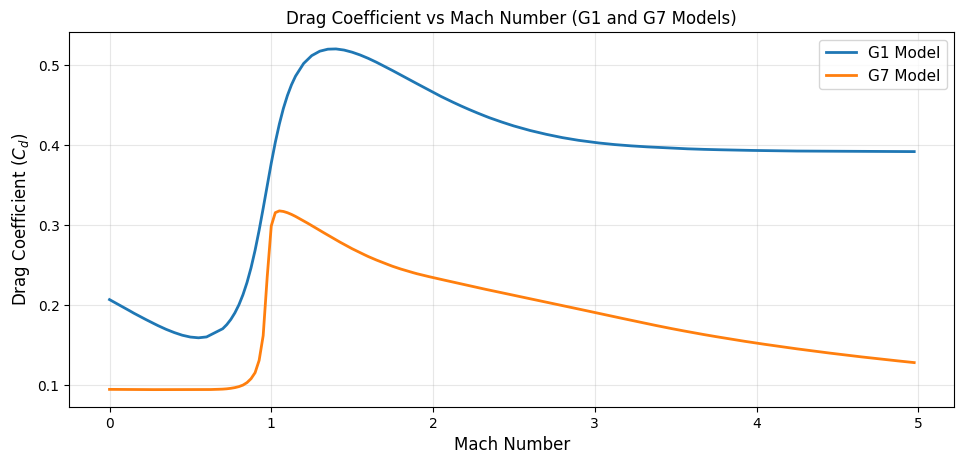

In [10]:
ballistics_G1 = Ballistics(reference_model="G1")
ballistics_G7 = Ballistics(reference_model="G7")

G1_Cd = []
G7_Cd = []
machs = []

#Sample Cd over mach range
mach_range = [0, 5]
numsteps = 200
mach_step = (mach_range[1] - mach_range[0]) / numsteps

for i in range(numsteps):
    mach_no = (i * mach_step) + mach_range[0]
    machs.append(mach_no)
    G1_Cd.append(ballistics_G1.Cd(mach_no))
    G7_Cd.append(ballistics_G7.Cd(mach_no))

plt.figure(figsize=(10, 5))
plt.plot(machs, G1_Cd, linewidth=2, label='G1 Model')
plt.plot(machs, G7_Cd, linewidth=2, label='G7 Model')
plt.xlabel('Mach Number', fontsize=12)
plt.ylabel('Drag Coefficient ($C_d$)', fontsize=12)
plt.title('Drag Coefficient vs Mach Number (G1 and G7 Models)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout(pad=2.0)
plt.show()

### Measured Trajectories

Before comparing simulated trajectories to measured data, it is useful to first visualize the measured trajectory drop for our selected cartridges.

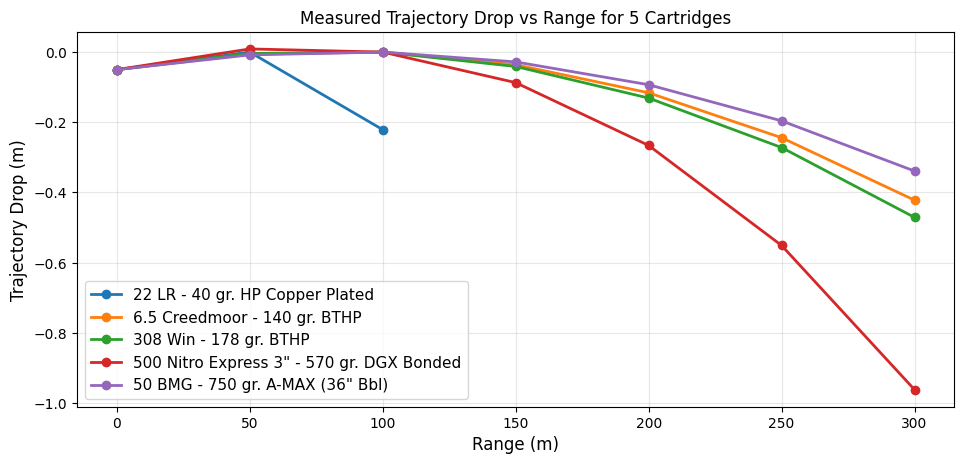

In [11]:
#Draw measured trajectories of our bullets
plt.figure(figsize=(10, 5))
for i in bullet_indices:
    bal = all_ballistics_G1[i]
    plt.plot(all_drop_data[i][:, 0], all_drop_data[i][:, 1], linewidth=2, marker='o',
             label=f"{bal.cartridge} - {bal.bullet}")
plt.xlabel('Range (m)', fontsize=12)
plt.ylabel('Trajectory Drop (m)', fontsize=12)
plt.title(f'Measured Trajectory Drop vs Range for {len(bullet_indices)} Cartridges', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout(pad=2.0)
plt.show()

### Trajectory at Multiple Firing Angles

To demonstrate the simulation's capability and explore the effect of launch angle on trajectory, we fire a single cartridge at several angles ranging from 15° to 90°. This bullet is fired using the same initial conditions as in the measured data (same offset for y, same initial velocity.) We observe realistic arcs and can visually confirm the shape of our curves is realistic.

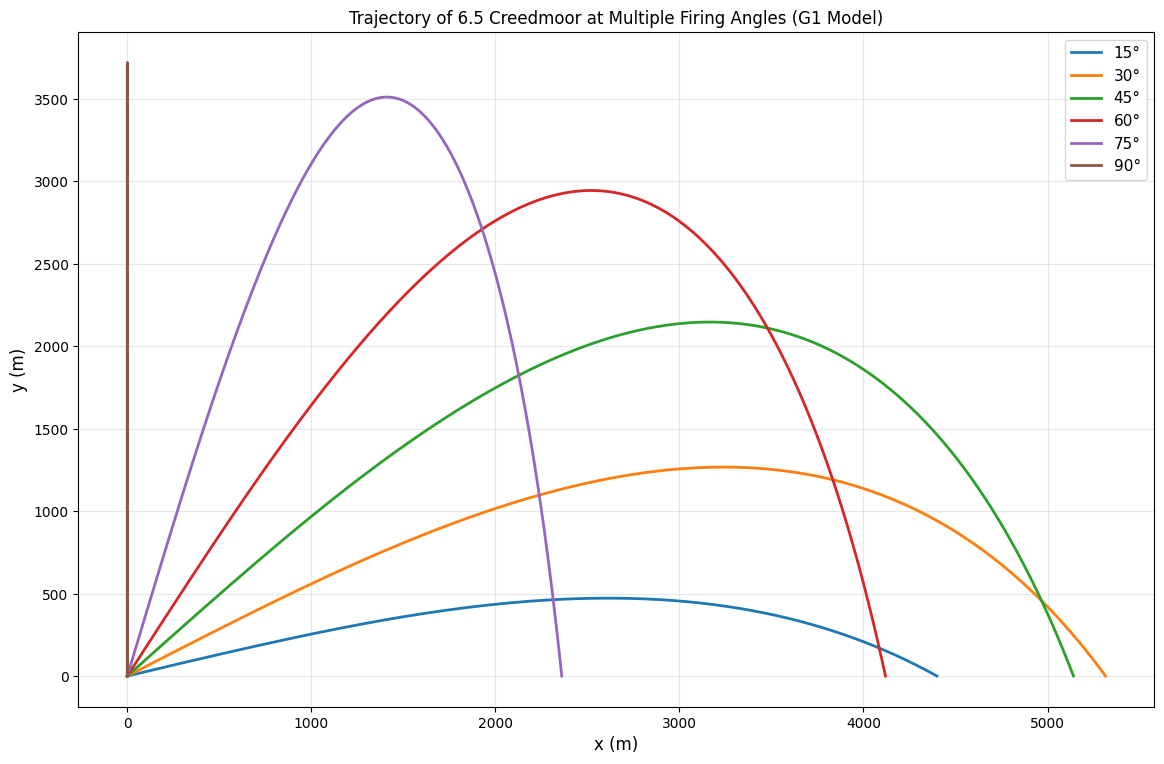

In [12]:
#Simulate a round with a real coefficient at various angles
firing_angles = [15, 30, 45, 60, 75, 90]
test_idx = bullet_indices[1]
timespan = [0, 100]
vel_test = all_velocity_data[test_idx][:, 1][0]
y_offset = all_drop_data[test_idx][:, 1][0]

plt.figure(figsize=(12, 8))

for firing_angle in firing_angles:
    firing_angle_rad = np.deg2rad(firing_angle)
    vx_0 = vel_test * np.cos(firing_angle_rad)
    vy_0 = vel_test * np.sin(firing_angle_rad)
    
    y0 = np.array([0, y_offset, vx_0, vy_0])
    
    y, t = solve_ode(projectile, timespan, y0, EulerRichardson,
                     all_ballistics_G1[test_idx], first_step=0.0005, y_ground=y_offset)
    plt.plot(y[:, 0], y[:, 1], linewidth=2, label=f'{firing_angle}°')

plt.xlabel('x (m)', fontsize=12)
plt.ylabel('y (m)', fontsize=12)
plt.title(f'Trajectory of {all_ballistics_G1[test_idx].cartridge} at Multiple Firing Angles (G1 Model)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout(pad=2.0)
plt.show()

### Simulated vs Measured Trajectory (G1 Model)

With the simulation and zeroing tools established, we now run `analyze_cartridge` on each of the selected bullets using the G1 reference model. For each cartridge, the function zeros the rifle at 100 m, simulates the full trajectory, and compares it against the Hornady measured data. The resulting panels show our model in relation to measured data, as well as the MSE (Mean squared Error) between the two. We use MSE because it is dynamic to differing lengths of measured data and thus our model holds up for the two entries in the master table that only have two measured data points; this also future-proofs our methods for other datasets.

In [1]:
#Run G1 analysis on selected cartridges
for idx in bullet_indices:
    analyze_cartridge(csv_idx=idx, printt=True)

NameError: name 'bullet_indices' is not defined

### Full Catalog G1 Error Analysis

To determine which bullets the G1 model handles best and worst, we run `analyze_cartridge` across the entire Hornady catalog with plotting disabled and collect position and velocity MSE for each entry. The results are sorted to reveal the top and bottom performers. This gives a broad picture of G1 model accuracy before introducing the G7 alternative.

> **Note:** This analysis takes some time. Set `analyze_all_cartridges = True` to execute.

Processing complete


Best by Position G1



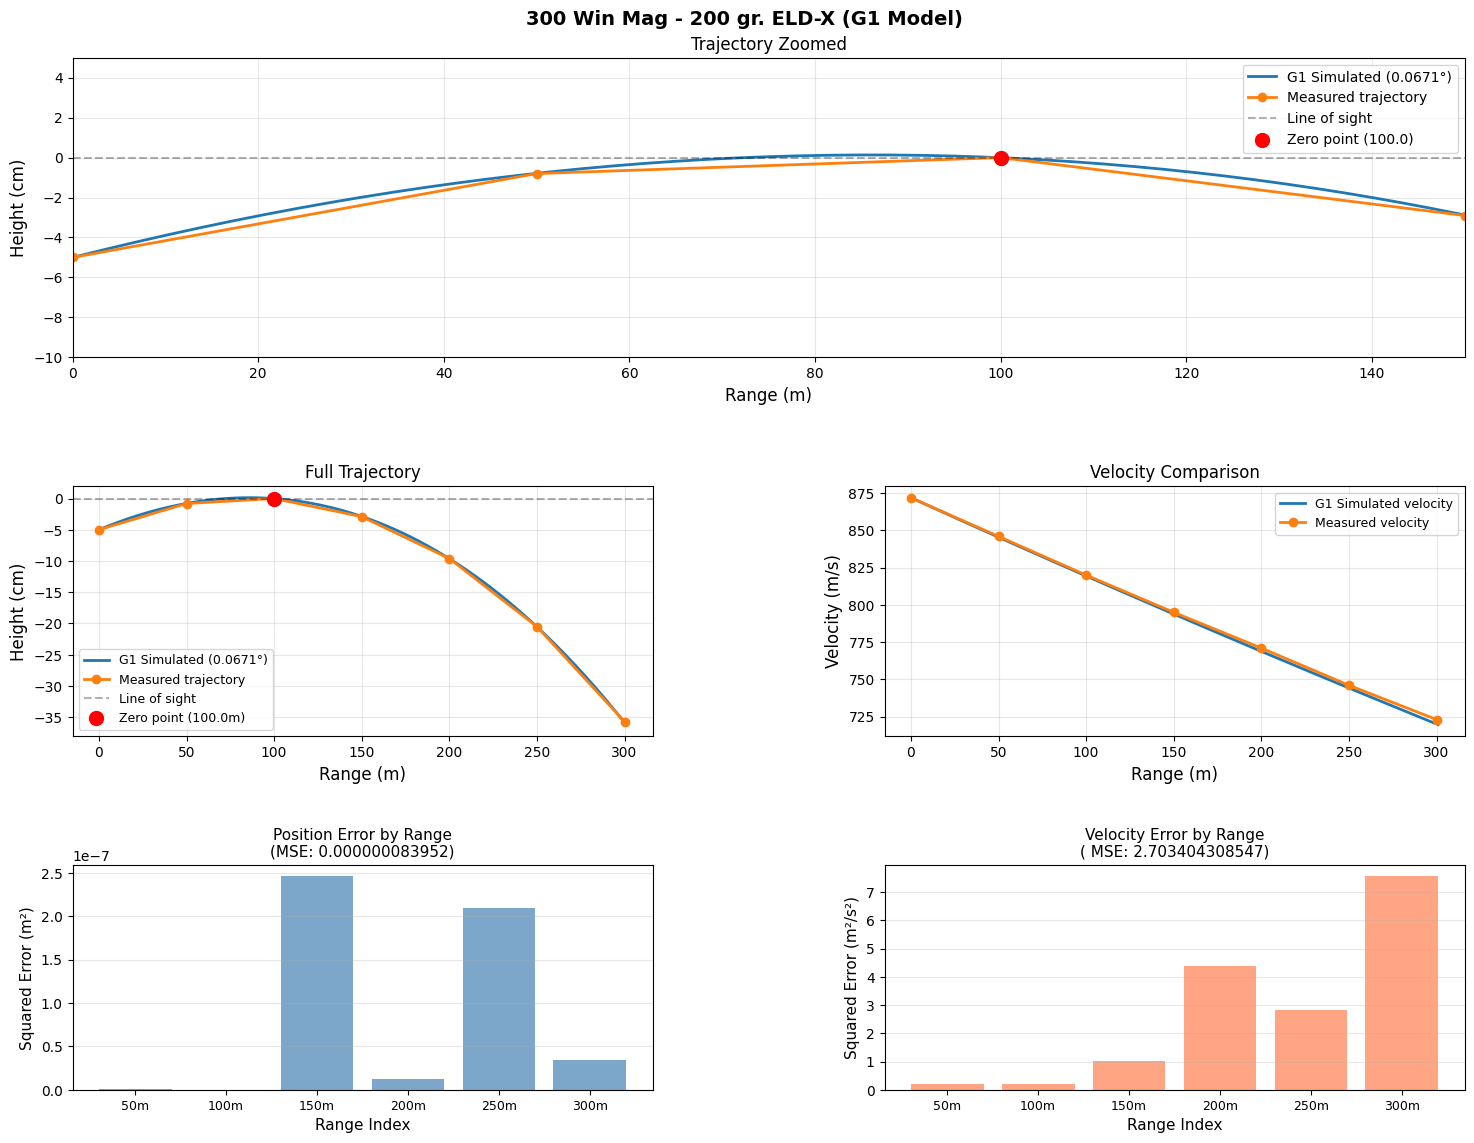


Worst by Position G1



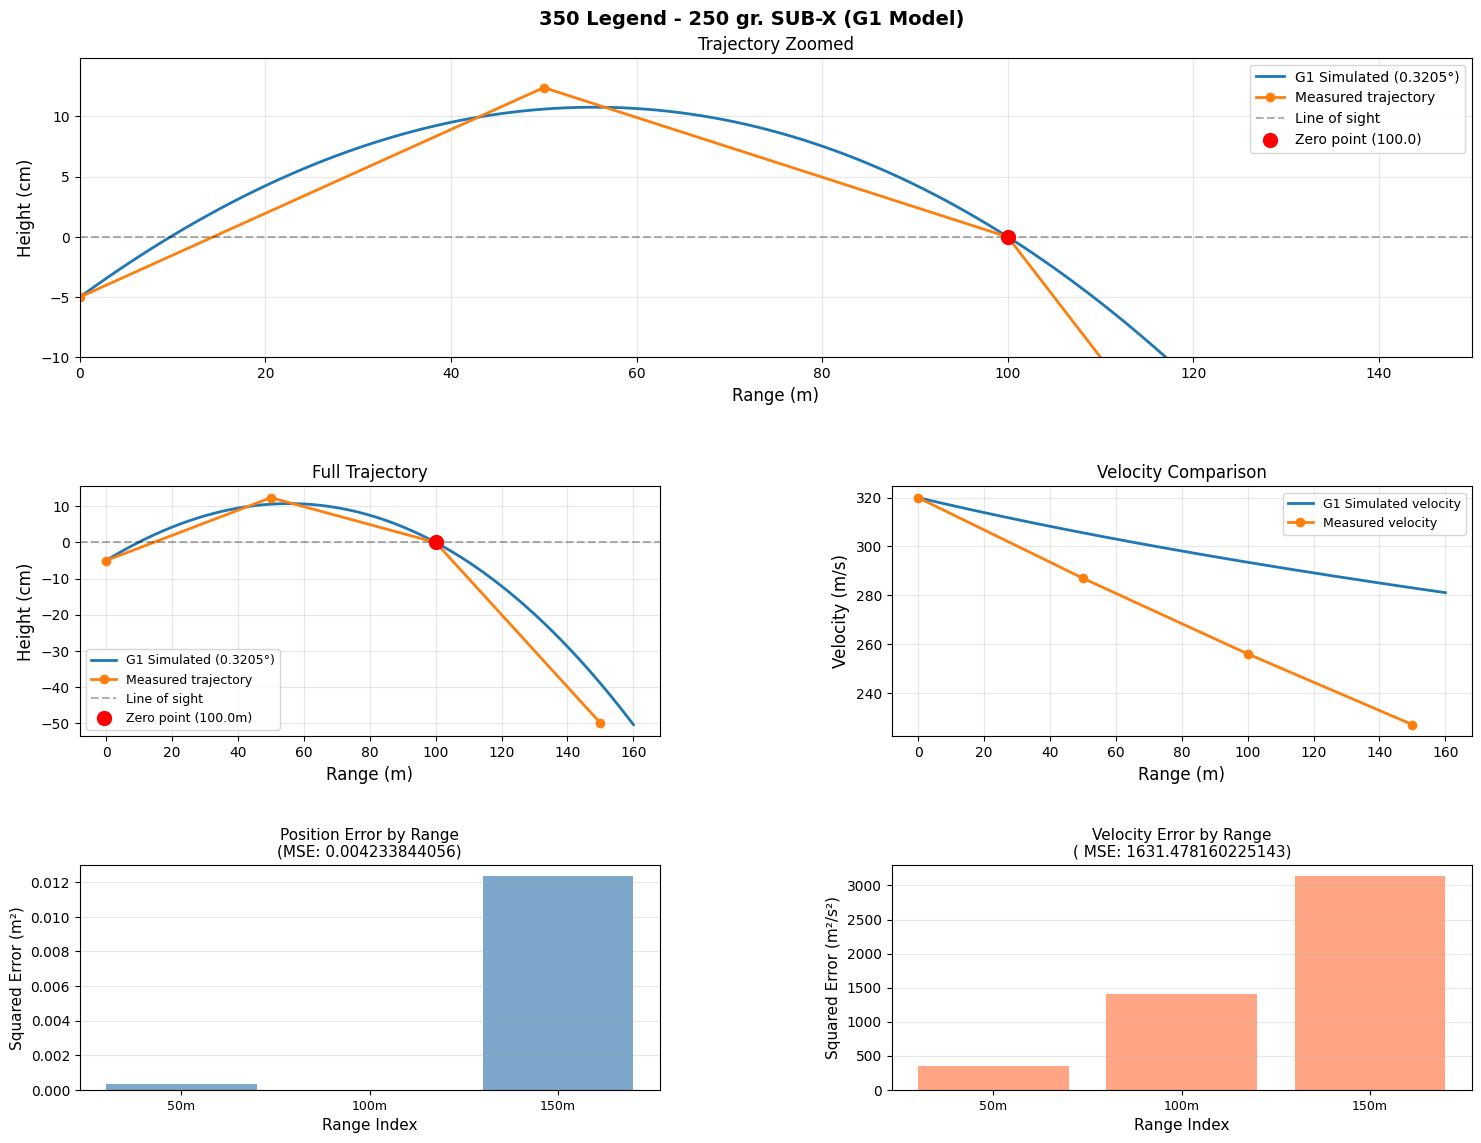


Top Five by Position Error, G1

1. Index 184: 300 Win Mag 200 gr. ELD-X (MSE: 0.000000083952)
2. Index 85: 6.5 Creedmoor 143 gr. ELD-X (MSE: 0.000000091774)
3. Index 207: 338 Lapua Mag 285 gr. ELD Match (MSE: 0.000000101101)
4. Index 171: 300 RCM 178 gr. ELD-X (MSE: 0.000000175401)
5. Index 106: 7mm-08 Rem 139 gr. InterLock SP (MSE: 0.000000179953)

Bottom Five by Position Error, G1

1. Index 211: 350 Legend 250 gr. SUB-X (MSE: 0.004233844056)
2. Index 4: 17 HMR 20 gr. XTP (MSE: 0.003392692045)
3. Index 2: 17 HMR 15.5 gr. NTX (MSE: 0.003359841871)
4. Index 10: 22 WMR 25 gr. NTX (MSE: 0.003043514608)
5. Index 122: 30 Carbine 110 gr. FTX (20" Bbl) (MSE: 0.001900054424)

Top Five by Velocity Error, G1

1. Index 12: 22 LR 40 gr. LRN (MSE: 0.036899074659)
2. Index 131: 30-30 Win 175 gr. SUB-X (MSE: 0.080196054322)
3. Index 127: 300 Blackout 190 gr. SUB-X (16" Bbl) (MSE: 0.105215185367)
4. Index 244: 450 Bushmaster 395 gr. SUB-X (20" Bbl) (MSE: 0.105654918041)
5. Index 247: 45-70 Govt 410 g

In [ ]:
#collect errors from all models. Can take a while. On M4 Macbook Air 8GB takes ~ 5.5 minutes
analyze_all_cartridges = True
G1errors = []

if analyze_all_cartridges:
    for idx in range(len(all_ballistics_G1)):
        print(f"Processing: {idx}/{len(all_ballistics_G1)}", end='\r', flush=True)

        pos_err, vel_err = analyze_cartridge(idx, plot=False, model="G1")
        bal = all_ballistics_G1[idx]
        G1errors.append(np.array([idx,pos_err,vel_err]))
    print("Processing complete")
    G1errors_array = np.array(G1errors)

    #sorted by position error
    sorted_by_pos = G1errors_array[np.argsort(G1errors_array[:, 1])]

    #sorted by velocity error
    sorted_by_vel = G1errors_array[np.argsort(G1errors_array[:, 2])]

    print("\n\nBest by Position G1\n")
    analyze_cartridge(int(sorted_by_pos[0, 0]), plot=True, model="G1")
    print("\nWorst by Position G1\n")
    analyze_cartridge(int(sorted_by_pos[-1, 0]), plot=True, model="G1")

    print("\nTop Five by Position Error, G1\n")
    for i in range(5):
        idx = int(sorted_by_pos[i, 0])
        print(f"{i+1}. Index {idx}: {all_ballistics_G1[idx].cartridge} {all_ballistics_G1[idx].bullet} (MSE: {sorted_by_pos[i, 1]:.12f})")

    print("\nBottom Five by Position Error, G1\n")
    for i in range(1, 6):
        idx = int(sorted_by_pos[-i, 0])
        print(f"{i}. Index {idx}: {all_ballistics_G1[idx].cartridge} {all_ballistics_G1[idx].bullet} (MSE: {sorted_by_pos[-i, 1]:.12f})")
        
    print("\nTop Five by Velocity Error, G1\n")
    for i in range(5):
        idx = int(sorted_by_vel[i, 0])
        print(f"{i+1}. Index {idx}: {all_ballistics_G1[idx].cartridge} {all_ballistics_G1[idx].bullet} (MSE: {sorted_by_vel[i, 2]:.12f})")

    print("\nBottom Five by Velocity Error, G1\n")
    for i in range(1, 6):
        idx = int(sorted_by_vel[-i, 0])
        print(f"{i}. Index {idx}: {all_ballistics_G1[idx].cartridge} {all_ballistics_G1[idx].bullet} (MSE: {sorted_by_vel[-i, 2]:.12f})")

   


### G1 Error Analysis

The top performing bullets by MSE tend to be larger rounds, but not the largest. It is apparent that some of the worst performers are the smallest rounds. There doesn't seem to be an immediate indicator of best or worst performers by data available in the spreadsheet, though it's possible there are characteristics of the rounds themselves that are apparent in their physical dimensions. It appears it's possible the worst performers are unique rounds, such as the SUB-X which has low overall velocity and perhaps a unique shape or weight/powder ratio.

Interesting to note is that velocity error and position error are not 1:1, in fact there is little overlap between them (except for the light HMR bullets.) This is interesting because one might think that if one is accurate then the other ought to be as well. This may be due to simulated methods, or possibly precision differences in measurement. This question may be an avenue for future investigation.

### Four-Model Comparison

For a single matched bullet, we simulate trajectories using all four available models: G1, G1 Interpolated, G7, and G7 Interpolated. Overlaying these with the measured data reveals how each reference model and BC treatment affects trajectory and velocity accuracy. The MSE table at the bottom provides a quantitative ranking.

Bullet: 338 Lapua Mag 270 gr. ELD-X
BC index: 31, Master index: 206, v0: 853.0 m/s

  G1              angle = 0.06852°
  G1 Interp       angle = 0.06852°
  G7              angle = 0.06789°
  G7 Interp       angle = 0.06852°


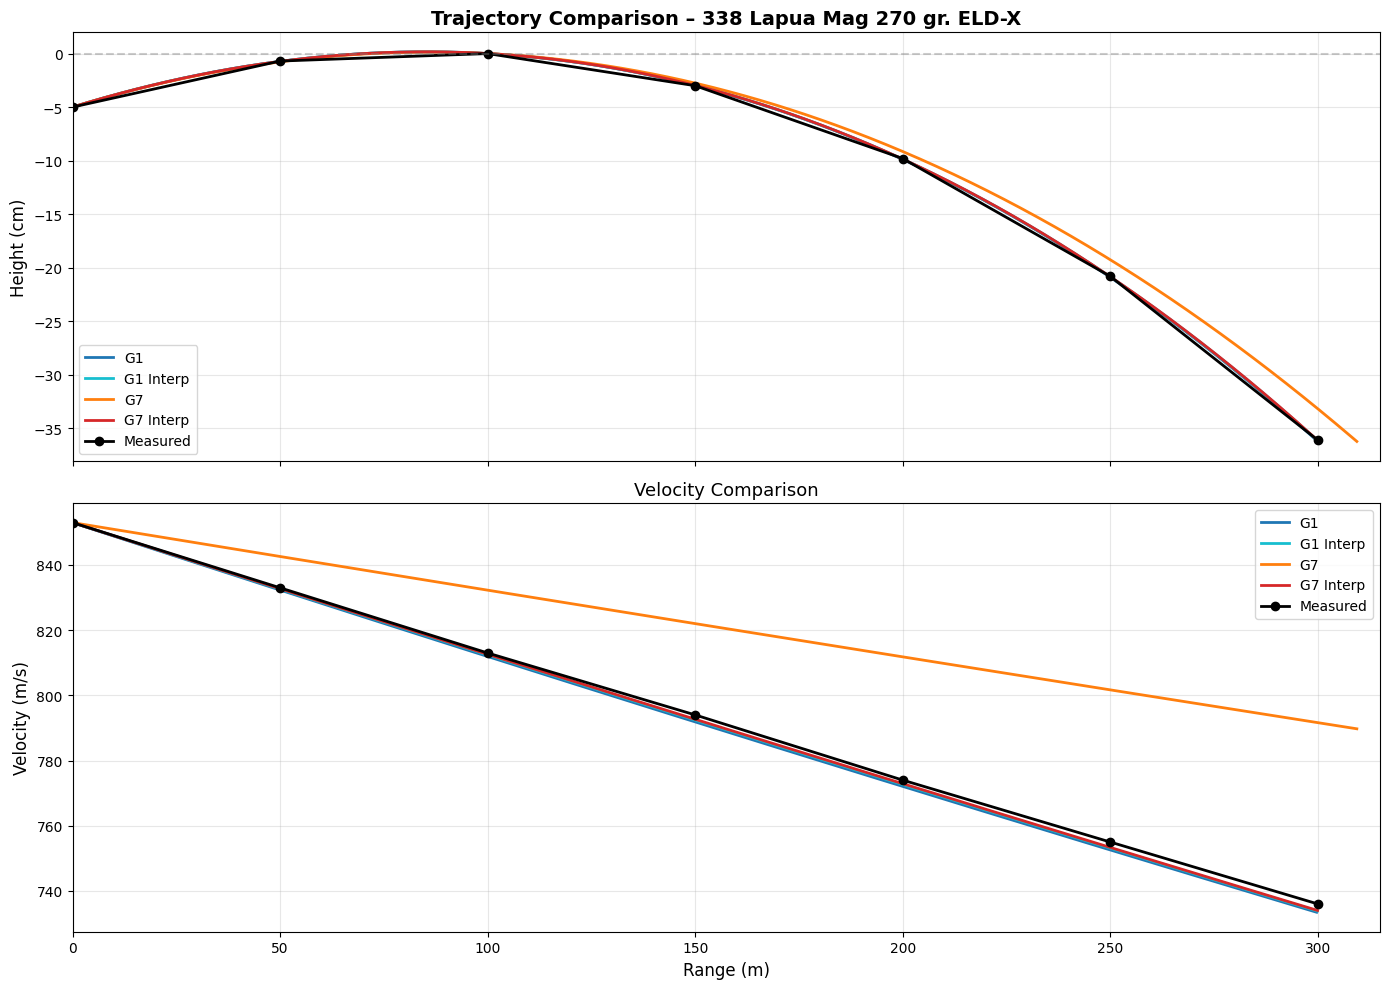


Model                 Pos MSE (m²)     Vel MSE (m²/s²)
--------------------------------------------------------
G1                2.6515497033e-07    3.6985181295e+00
G1 Interp         2.3010639683e-07    2.2391040617e+00
G7                1.9156358572e-04    1.3250794878e+03
G7 Interp         2.1184218436e-07    1.7331608002e+00


In [ ]:
#Compare all four ballistic models
match_idx = 29
bc_idx, master_idx = bc_to_master[match_idx]

#Ballistic objects for the four models
models = {
    'G1':        all_ballistics_G1[master_idx],
    'G1 Interp': interp_ballistics_G1[bc_idx],
    'G7':        all_ballistics_G7[master_idx],
    'G7 Interp': interp_ballistics_G7[bc_idx],
}

#Measured data for this bullet
drop_data = all_drop_data[master_idx]
vel_data  = all_velocity_data[master_idx]

print(f"Bullet: {all_ballistics_G1[master_idx].cartridge} {all_ballistics_G1[master_idx].bullet}")
print(f"BC index: {bc_idx}, Master index: {master_idx}, v0: {vel_data[0, 1]:.1f} m/s\n")

#Simulate cartridge with each model
results = {}
for label, bal in models.items():
    sim = simulate_cartridge(csv_idx=master_idx, ballistic_object=bal)
    print(f"  {label:14s}  angle = {sim['angle']:.5f}°")
    results[label] = (sim['x'], sim['y'], sim['v'])

#Plotting
colors = {'G1': 'tab:blue', 'G1 Interp': 'tab:cyan',
          'G7': 'tab:orange', 'G7 Interp': 'tab:red'}
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

#Trajectory (drop)
ax = axes[0]
for label, (x, y, v) in results.items():
    ax.plot(x, 100*y, linewidth=2, color=colors[label], label=label)
ax.plot(drop_data[:, 0], 100*drop_data[:, 1], 'ko-', linewidth=2,
        markersize=6, label='Measured')
ax.axhline(0, color='grey', ls='--', alpha=0.4)
ax.set_ylabel('Height (cm)', fontsize=12)
ax.set_title(f'Trajectory Comparison – {all_ballistics_G1[master_idx].cartridge} '
             f'{all_ballistics_G1[master_idx].bullet}', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, drop_data[-1, 0] * 1.05)

#Velocity
ax = axes[1]
for label, (x, y, v) in results.items():
    ax.plot(x, v, linewidth=2, color=colors[label], label=label)
ax.plot(vel_data[:, 0], vel_data[:, 1], 'ko-', linewidth=2,
        markersize=6, label='Measured')
ax.set_xlabel('Range (m)', fontsize=12)
ax.set_ylabel('Velocity (m/s)', fontsize=12)
ax.set_title('Velocity Comparison', fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#Print MSE summary using compute_errors
print(f"\n{'Model':14s}  {'Pos MSE (m²)':>18s}  {'Vel MSE (m²/s²)':>18s}")
print('-' * 56)
for label, (x_sim, y_sim, v_sim) in results.items():
    sim_dict = {'x': x_sim, 'y': y_sim, 'v': v_sim}
    pos_mse, vel_mse, _, _, _ = compute_errors(sim_dict, master_idx)
    print(f"{label:14s}  {pos_mse:18.10e}  {vel_mse:18.10e}")

### Model Comparison for 338 Lapua Mag 270 Gr. ElD-X

For this cartridge we observe the G7 Interpolated model to be the most accurate, though it is in the same order of magnitude of error as G1 and G1 Interp. We observe significantly worse performance from the G7 model with a singular B_C. This is to be expected and is in reality an unfair comparison, the master Hornady ballistics spreadsheet provides G1 ballistic coefficients because it is the industry standard. Using the G7 reference model with a G1 ballistic coefficient predictably provides poor results.

### Optimal Model Rating Across Matched Bullets

For every bullet that matched between the supplemental and master datasets, we simulate with all four models and record which one produces the lowest position MSE. This produces a summary showing how often each model is the best choice.

> **Note:** This cell takes several minutes to run. It loops through all matched bullets with four simulations each.

In [ ]:
#Loop through bullets we have a match for and find optimal model
#Takes ~4 minutes on M4 Macbook Air
rate_all_models = True
model_names = ['G1', 'G1 Interp', 'G7', 'G7 Interp']

bc_to_master_rated = []

if rate_all_models:
    for map_idx, (bc_idx, master_idx) in enumerate(bc_to_master):
        print(f"Processing match {map_idx}/{len(bc_to_master)}: {all_ballistics_G1[master_idx].cartridge} {all_ballistics_G1[master_idx].bullet}", end='\r', flush=True)
        
        #Build ballistic objects for all four models
        model_objects = [
            all_ballistics_G1[master_idx],
            interp_ballistics_G1[bc_idx],
            all_ballistics_G7[master_idx],
            interp_ballistics_G7[bc_idx],
        ]
        
        #Compute position MSE for each model
        mse_values = []
        for bal in model_objects:
            try:
                sim = simulate_cartridge(csv_idx=master_idx, ballistic_object=bal, dt=0.002)
                pos_mse, _, _, _, _ = compute_errors(sim, master_idx)
                mse_values.append(pos_mse)
            except:
                #If simulation fails, assign high cost
                mse_values.append(100000)
        
        #Find the model with the lowest position MSE
        best_model_idx = np.argmin(mse_values)
        
        #Append original tuple with best model index
        bc_to_master_rated.append((bc_idx, master_idx, best_model_idx))

    print(f"\nProcessing complete. Rated {len(bc_to_master_rated)} matched bullets.\n")

    #Print summary table
    header = 'Map Idx'.ljust(10) + 'Master Idx'.ljust(12) + 'Cartridge + Bullet'.ljust(55) + 'Best Model'
    print(header)
    print('-' * 90)
    for map_idx, (bc_idx, master_idx, best_model) in enumerate(bc_to_master_rated):
        cart = all_ballistics_G1[master_idx].cartridge
        bul = all_ballistics_G1[master_idx].bullet
        line = str(map_idx).ljust(10) + str(master_idx).ljust(12) + f'{cart} {bul}'.ljust(55) + model_names[best_model]
        print(line)

    #Count how many times each model wins
    print("\nModel win counts:")
    for i, name in enumerate(model_names):
        count = sum(1 for _, _, best in bc_to_master_rated if best == i)
        print(f"  {name}: {count}")

Processing match 29/30: 338 Lapua Mag 270 gr. ELD-XXD-X
Processing complete. Rated 30 matched bullets.

Map Idx   Master Idx  Cartridge + Bullet                                     Best Model
------------------------------------------------------------------------------------------
0         52          243 Win 90 gr. ELD-X                                   G1 Interp
1         44          6mm ARC 103 gr. ELD-X                                  G7 Interp
2         58          6mm Creedmoor 103 gr. ELD-X                            G1 Interp
3         65          25-06 Rem 110 gr. ELD-X                                G1 Interp
4         69          257 Wby Mag 110 gr. ELD-X                              G7 Interp
5         85          6.5 Creedmoor 143 gr. ELD-X                            G1
6         88          6.5 PRC 143 gr. ELD-X                                  G1 Interp
7         99          270 Win 145 gr. ELD-X                                  G1 Interp
8         101         270 WS

### Optimal Model Analysis

From the table above we can see that for bullets with supplimental ballistic coefficient data, interpolated models generally provide a more accurate simulation - however this is not perscriptive. There isn't an immediate pattern for which model (G1 Interp or G7 Interp) performs best based on position in the list, which serves as a proxy for size of bullet. This indicates that the optimal model is not directly related to the weight of the bullet itself or the powder, but likely a factor of the physical shape of the bullet. Further analysis may include incorporating numerical methods to quantify bullet shape and relate that to optimal model performance or amount of error.

### GEE Analysis

The Greatest Extent of Elevation (GEE) determines the flattest possible trajectory for each cartridge, measured as the firing angle where the bullet stays within 5 cm of the line of sight for the longest range. For each bullet in the catalog, we find the GEE angle using `zero_cartridge` in GEE mode with the G1 reference model, simulate the trajectory, and interpolate the range at which the bullet drops below −5 cm.

For consistency we will use the G1 singular coefficient model for all bullets in this analysis.

The results are sorted by GEE range to identify which cartridges maintain the flattest trajectories.

> **Note:** This analysis takes some time. On an M4 Macbook Air run time is approx. 4 minutes. Set `run_gee_analysis = True` to execute.

In [ ]:
#GEE calculations
#To find the GEE angle we zero the rifle such that the apex of the trajectory is 5cm
#Then find the range at which the bullet drops below -gee_height (i.e. -5cm)
run_gee_analysis = True
gee_height = 0.05

gee_results = []

if run_gee_analysis:
    for idx in range(len(all_ballistics_G1)):
        print(f"Processing GEE: {idx}/{len(all_ballistics_G1)}", end='\r', flush=True)
        #Get ballistics model
        bal = all_ballistics_G1[idx]
        
        #Find the GEE angle (angle where peak height = gee_height)
        v0 = all_velocity_data[idx][:,1][0]
        initial_y = all_drop_data[idx][:,1][0]
        gee_angle = zero_cartridge(idx, ballistic_object=bal, gee=True, gee_height=gee_height, scope_offset=initial_y)
        
        #Simulate with the GEE angle
        angle_rad = np.deg2rad(gee_angle)
        y0 = np.array([0, initial_y, v0 * np.cos(angle_rad), v0 * np.sin(angle_rad)])
        y, t = solve_ode(projectile, [0, 10], y0, EulerRichardson, bal, first_step=0.002)
        
        x_data = y[:, 0]
        y_data = y[:, 1]
        
        #Find the first point after the peak where bullet drops below -gee_height
        peak_idx = np.argmax(y_data)
        below_indices = np.where(y_data[peak_idx:] < -gee_height)[0]
        
        if len(below_indices) > 0:
            gee_range = x_data[peak_idx + below_indices[0]]
        else:
            gee_range = x_data[-1]
        
        gee_results.append((idx, gee_range, gee_angle))

    print(f"\nGEE processing complete for {len(gee_results)} bullets.\n")

    #Sort by GEE range descending (farthest first)
    gee_results_sorted = sorted(gee_results, key=lambda x: x[1], reverse=True)

    #Print top 10 bullets by GEE range
    print(f"{'Rank':<6} {'Idx':<6} {'Sim GEE (m)':<14} {'Meas GEE (m)':<15} {'Diff (m)':<12} {'Angle (deg)':<14} {'Cartridge + Bullet'}")
    print('-' * 120)
    for rank, (idx, gee_range, gee_angle) in enumerate(gee_results_sorted[:10], 1):
        cart = all_ballistics_G1[idx].cartridge
        bul = all_ballistics_G1[idx].bullet
        meas = all_measured_gee[idx]
        diff = gee_range - meas if meas > 0 else float('nan')
        print(f"{rank:<6} {idx:<6} {gee_range:<14.2f} {meas:<15.2f} {diff:<12.2f} {gee_angle:<14.6f} {cart} {bul}")

    print(f"\n--- Bottom 5 ---")
    for rank, (idx, gee_range, gee_angle) in enumerate(gee_results_sorted[-5:], len(gee_results_sorted)-4):
        cart = all_ballistics_G1[idx].cartridge
        bul = all_ballistics_G1[idx].bullet
        meas = all_measured_gee[idx]
        diff = gee_range - meas if meas > 0 else float('nan')
        print(f"{rank:<6} {idx:<6} {gee_range:<14.2f} {meas:<15.2f} {diff:<12.2f} {gee_angle:<14.6f} {cart} {bul}")

Processing GEE: 259/260
GEE processing complete for 260 bullets.

Rank   Idx    Sim GEE (m)    Meas GEE (m)    Diff (m)     Angle (deg)    Cartridge + Bullet
------------------------------------------------------------------------------------------------------------------------
1      39     287.89         270.00          17.89        0.066172       22-250 Rem 35 gr. NTX
2      8      287.20         264.00          23.20        0.068281       204 Ruger 32 gr. V-MAX (26" Bbl)
3      7      282.53         263.00          19.53        0.067109       204 Ruger 24 gr. NTX (26" Bbl)
4      9      282.39         252.00          30.39        0.072109       204 Ruger 40 gr. V-MAX (26" Bbl)
5      41     282.12         254.00          28.12        0.071094       22-250 Rem 50 gr. V-MAX
6      47     279.23         250.00          29.23        0.072188       243 Win 58 gr. V-MAX
7      40     270.05         238.00          32.05        0.074609       22-250 Rem 50 gr. V-MAX
8      48     269.04  

### GEE Analysis

From the above table observe that the flattest performers are small-mid size rounds between ~30 and ~55 gr. The worst performers include large rounds as well as some of the smallest .22 rounds. This indicates complexity when determining the bullets with the flattest trajectories. Further analysis may investigate the relation between bullet weight, bullet shape, powder weight and the shape of the curve. To note the SUB-X seem highly represented in the worst performing by GEE rounds, whereas the V-MAX is consistently a top performer.

It is also worth noting that the simulated GEE range is generally higher than it's measured counterpart, this may be due in part to the methodologies for ranging for GEE in practice. 

### GEE Visualization

The plot below shows the trajectory of the top-ranked GEE cartridge.

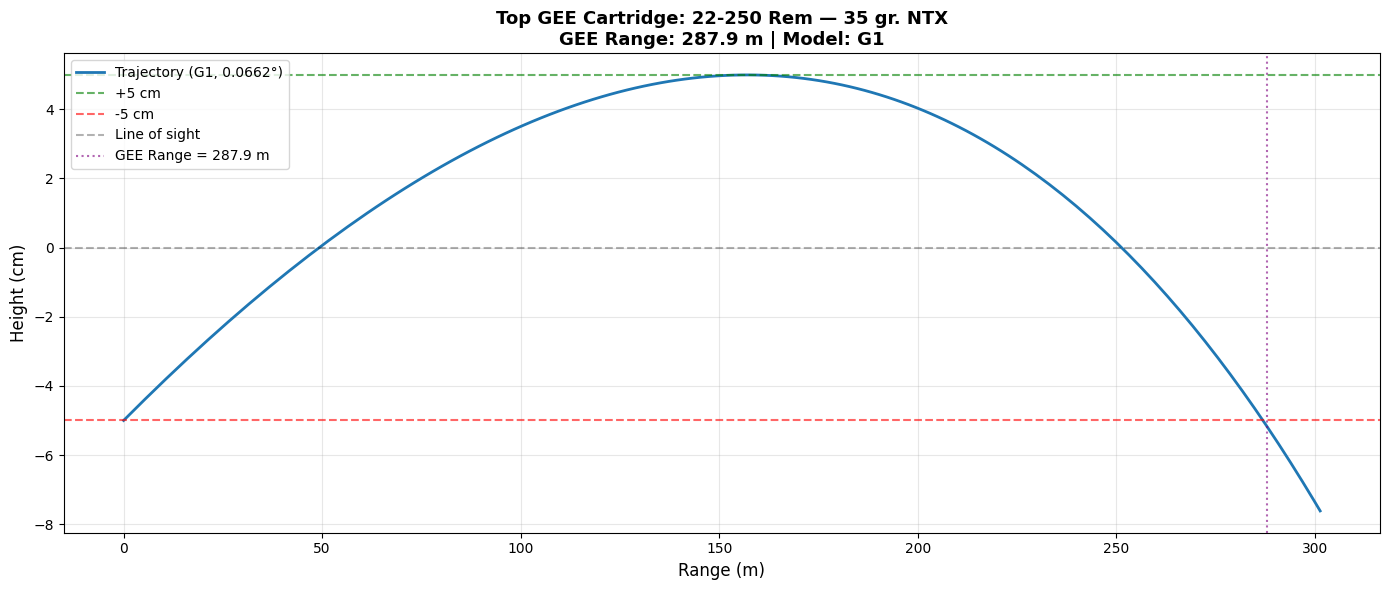

In [ ]:
#Plot the top-ranked GEE cartridge trajectory
top_idx, top_gee_range, top_gee_angle = gee_results_sorted[0]

bal_top = all_ballistics_G1[top_idx]

#Simulate with the GEE angle
v0_top = all_velocity_data[top_idx][:, 1][0]
initial_y_top = all_drop_data[top_idx][:, 1][0]
angle_rad_top = np.deg2rad(top_gee_angle)
y0_top = np.array([0, initial_y_top, v0_top * np.cos(angle_rad_top), v0_top * np.sin(angle_rad_top)])
y_top, t_top = solve_ode(projectile, [0, 10], y0_top, EulerRichardson, bal_top, first_step=0.002)

x_plot = y_top[:, 0]
y_plot = y_top[:, 1]

#Trim to GEE range
mask = x_plot <= top_gee_range * 1.05
x_plot = x_plot[mask]
y_plot = y_plot[mask]

cart_name = all_ballistics_G1[top_idx].cartridge
bul_name = all_ballistics_G1[top_idx].bullet

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(x_plot, 100 * y_plot, linewidth=2, label=f'Trajectory (G1, {top_gee_angle:.4f}°)')
ax.axhline(y=100 * gee_height, color='green', linestyle='--', alpha=0.6, label=f'+{100*gee_height:.0f} cm')
ax.axhline(y=-100 * gee_height, color='red', linestyle='--', alpha=0.6, label=f'-{100*gee_height:.0f} cm')
ax.axhline(y=0, color='k', linestyle='--', alpha=0.3, label='Line of sight')
ax.axvline(x=top_gee_range, color='purple', linestyle=':', alpha=0.6, label=f'GEE Range = {top_gee_range:.1f} m')
ax.set_xlabel('Range (m)', fontsize=12)
ax.set_ylabel('Height (cm)', fontsize=12)
ax.set_title(f'Top GEE Cartridge: {cart_name} — {bul_name}\nGEE Range: {top_gee_range:.1f} m | Model: G1', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Interpretation

The above analysis demonstrates the importance of using appropriate parameters, in this case ballistic coefficient, with the model chosen. We observe the relative superiority of a finer grained/adaptive model in the relative performance of the dynamic ballistic cofficient based on mach speed. 

Overall, we observe highly accurate simulations relative to measured trajectories. Where models are highly inaccurate, such as in the case of using a G7 model with a G1 ballistic coefficient, the discrepancies are expected. Several bullets exhibit unusual tail behavior, immediate inspection indicates this may be due to the lower velocities and lighter bullets.

Comparisons of model performance demonstrate the complexity of matching a bullet to a particular model, and convey the importance of using experimental data to match physical behavior to a simulated model. From the analysis several questions arise that are potential avenues for further exploration:

* The impact of bullet weight, as well as powder weight, on the GEE trajectory as well as optimal model.
* Incorporating physical shape characteristics of the bullet into similar analysis to better predict what model may perform the best for a given bullet.
* Using the same bullet and increasing the powder weight (hot loading) to see to what extent GEE range can be increased for a given bullet. Gathering experimental data with the same bullet and varying powder weights can open up many avenues of analysis. 